In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import stats
from scipy.signal import find_peaks
from sklearn.cluster import KMeans


In [169]:
# Примеры для тестирования

'''https://cs8.pikabu.ru/post_img/2016/09/29/7/og_og_1475149607270765572.jpg
https://images.tut-files.ru/files/127754/918047_html_cb968387f91654a0.jpg !!!
https://www.digiseller.ru/preview/78244/p1_30509133931597.JPG !!!
https://boardrussia.ru/digital-shop/img/preview-78244-p1_30509134817160.JPG
https://studfile.net/html/2706/132/html_cIRc0NvMni.aLWd/img-VOgX7l.png
https://i.pinimg.com/originals/9f/4a/be/9f4abe8ecc4f45904b39135779edde80.jpg
https://abrakadabra.fun/uploads/posts/2022-02/1644407793_18-abrakadabra-fun-p-tekst-na-rukopisnii-31.png
https://mir-s3-cdn-cf.behance.net/projects/404/64368296977395.Y3JvcCw2NjIsNTE4LDc3LDkx.jpg
https://data3.proshkolu.ru/content/media/pic/std/2000000/1434000/1433283-abd9a80cc8f6c7a0.png !!!
https://www.digiseller.ru/preview/78244/p1_30509134057203.JPG !!!
https://ic.pics.livejournal.com/zan_ad/38075514/67226/67226_original.jpg !!!!!!!!!!!!
https://i.pinimg.com/736x/3b/51/a0/3b51a02e3c5d644223c2c8a2e33f2763.jpg
https://fanibani.ru/images/wp-content/uploads/2021/03/image053-51-837x720.jpg
https://vuz-24.ru/nex/images/image-554b09c7.png
https://i.pinimg.com/originals/3c/12/fd/3c12fd8f11c997ff710c100d8402e6ff.jpg !!!
https://fs03.metod-kopilka.ru/images/doc/70/71620/img1.jpg
https://cf3.ppt-online.org/files3/slide/j/JcS6g4ItWbrjKwhp8iQP7OAENCqHT3xRnBD1lf/slide-9.jpg
'''

'https://cs8.pikabu.ru/post_img/2016/09/29/7/og_og_1475149607270765572.jpg\nhttps://images.tut-files.ru/files/127754/918047_html_cb968387f91654a0.jpg !!!\nhttps://www.digiseller.ru/preview/78244/p1_30509133931597.JPG !!!\nhttps://boardrussia.ru/digital-shop/img/preview-78244-p1_30509134817160.JPG\nhttps://studfile.net/html/2706/132/html_cIRc0NvMni.aLWd/img-VOgX7l.png\nhttps://i.pinimg.com/originals/9f/4a/be/9f4abe8ecc4f45904b39135779edde80.jpg\nhttps://abrakadabra.fun/uploads/posts/2022-02/1644407793_18-abrakadabra-fun-p-tekst-na-rukopisnii-31.png\nhttps://mir-s3-cdn-cf.behance.net/projects/404/64368296977395.Y3JvcCw2NjIsNTE4LDc3LDkx.jpg\nhttps://data3.proshkolu.ru/content/media/pic/std/2000000/1434000/1433283-abd9a80cc8f6c7a0.png !!!\nhttps://www.digiseller.ru/preview/78244/p1_30509134057203.JPG !!!\nhttps://ic.pics.livejournal.com/zan_ad/38075514/67226/67226_original.jpg !!!!!!!!!!!!\nhttps://i.pinimg.com/736x/3b/51/a0/3b51a02e3c5d644223c2c8a2e33f2763.jpg\nhttps://fanibani.ru/images/

In [364]:
!wget "https://i.pinimg.com/736x/3b/51/a0/3b51a02e3c5d644223c2c8a2e33f2763.jpg" -O text.jpg

--2025-11-20 21:01:09--  https://i.pinimg.com/736x/3b/51/a0/3b51a02e3c5d644223c2c8a2e33f2763.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.56.109.78, 23.56.109.81, 2a04:4e42::84, ...
Connecting to i.pinimg.com (i.pinimg.com)|23.56.109.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126509 (124K) [image/jpeg]
Saving to: ‘text.jpg’

text.jpg            100%[===================>] 123.54K  --.-KB/s    in 0.01s   

2025-11-20 21:01:09 (11.4 MB/s) - ‘text.jpg’ saved [126509/126509]



In [405]:
from google.colab import files
uploaded = files.upload()

Saving photo_2025-11-20_23-46-29.jpg to photo_2025-11-20_23-46-29.jpg


In [406]:
pad = 20

img = cv2.imread('photo_2025-11-20_23-46-29.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU)

values, counts = np.unique(img_binary, return_counts=True)
background_color = values[np.argmax(counts).item()].item()
if background_color == 255:
  img_binary = 255 - img_binary

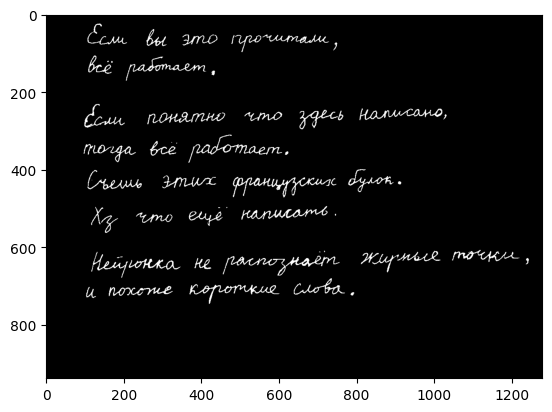

In [407]:
plt.imshow(img_binary, cmap='gray')
plt.show()

Detected text skew angle: -1.00°


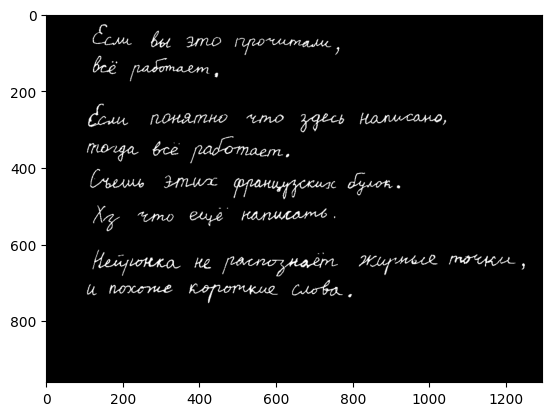

In [410]:
def detect_text_skew_angle(img_binary):
    """находит угол, под которым написан текст"""
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    cleaned = cv2.morphologyEx(img_binary, cv2.MORPH_CLOSE, kernel)

    edges = cv2.Canny(cleaned, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100,
                           minLineLength=100, maxLineGap=10)

    if lines is None:
        return 0

    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x2 - x1) > 20:
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            if -45 <= angle <= 45:
                angles.append(angle)

    if not angles:
        return 0

    median_angle = np.median(angles)

    print(f"Detected text skew angle: {median_angle:.2f}°")
    return median_angle


def deskew_image(image, angle):
    """Выравнивает изображение по заданному углу"""
    if abs(angle) < 0.5:
        return image.copy()

    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    M[0, 2] += (new_w - w) // 2
    M[1, 2] += (new_h - h) // 2

    deskewed = cv2.warpAffine(image, M, (new_w, new_h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)

    return deskewed


skew_angle = detect_text_skew_angle(img_binary)

if abs(skew_angle) > 1.0:
    img_binary = deskew_image(img_binary, skew_angle)
    img = deskew_image(img, skew_angle)

plt.imshow(img_binary, cmap='gray')
plt.show()

In [411]:
def show(list_of_images: list, titles: list = None, disable_ticks: bool = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])

    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

In [425]:
def merge_close_contours(row, hor_dist_thrs):
    'слияние близких друг к другу контуров в один общий контур'
    def change_format(box):
      """приведение box в нужную для convexHull форму"""
      x, y, w, h = box
      return [
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
      ]

    groups = []
    used = set()
    for i in range(len(row)):
        if i in used:
            continue

        current_group = [i]
        used.add(i)
        queue = [i]
        while queue:
            current_idx = queue.pop(0)

            for j in range(len(row)):
                if j in used:
                    continue
                distance_hor = calculate_rect_distance(row[current_idx],
                                                     row[j])

                if distance_hor < hor_dist_thrs:
                    current_group.append(j)
                    used.add(j)
                    queue.append(j)

        groups.append(current_group)


    merged_contours = []
    for group in groups:
        if len(group) == 1:
            merged_contours.append(np.array(change_format(row[group[0]])))
        else:
            merged_points = np.vstack([change_format(row[i]) for i in group])
            merged_contour = cv2.convexHull(merged_points)
            merged_contours.append(merged_contour)

    return merged_contours

def calculate_rect_distance(rect1, rect2):
    """нахождение расстояния по горизонтали между двумы контурами"""
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2

    left1, right1 = x1, x1 + w1
    left2, right2 = x2, x2 + w2

    if right1 < left2:
        distance_hor = left2 - right1
    elif right2 < left1:
        distance_hor = left1 - right2
    else:
        distance_hor = 0

    return distance_hor



In [433]:
def split_contours(x, y, w, h):
    """разделить контуры, состоящие из нескольки строк, по горизонтали"""
    projection = np.sum(img_binary[y:y+h, x:x+w], axis=1)
    threshold = np.max(projection) * 0.25

    lines = []
    in_line = False
    for i, val in enumerate(projection):
        if val > threshold and not in_line:
            start = i
            in_line = True
        elif val <= threshold and in_line:
            end = i
            in_line = False
            lines.append((start, end))
    if in_line:
      end = i
      lines.append((start, end))
    heights = [line[1] - line[0] for line in lines]
    mean_height = np.mean(heights)
    max_height = max(heights)
    lines = [line for line in lines  if (line[1] - line[0]) > max(mean_height * 0.6, max_height * 0.2)]
    snapshots = [img_binary[y + line[0]:y + line[1], x:x + w] for line in lines]

    contours = []
    for i, im in enumerate(snapshots):
      contours_im, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

      for contour in contours_im:
        x_, y_, w, h = cv2.boundingRect(contour)
        contours.append((x + x_, y + lines[i][0] + y_, w, h))
    return contours



def group_contours_histogram(contours, min_peaks=1, bins=50):
    """группировка по строкам"""
    img_area = img.shape[0] * img.shape[1]
    bboxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.boundingRect(cnt)[2] * cv2.boundingRect(cnt)[3] < img_area * 0.6]
    y_centers = [y + h/2 for _, y, _, h in bboxes]

    hist, bin_edges = np.histogram(y_centers, bins=bins)
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge', alpha=0.7)
    plt.show()

    peaks, _ = find_peaks(hist)

    if len(hist) > 1:
        if hist[0] > hist[1]:
            peaks = np.concatenate(([0], peaks))
        if hist[-1] > hist[-2]:
            peaks = np.concatenate((peaks, [len(hist)-1]))

    row_centers = [(bin_edges[peak] + bin_edges[peak + 1]) / 2 for peak in peaks]

    rows = [[] for _ in range(len(row_centers))]

    def add_splitted_contours(splitted_contours):
      """распределение разделённых контуров по группам"""
      bbox_centers = [y + h / 2 for _, y, _, h in splitted_contours]
      distances = [[abs(bbox_center - row_center) for row_center in row_centers] for bbox_center in bbox_centers]
      closest_rows = np.argmin(distances, axis=1)
      for i, row_idx in enumerate(closest_rows):
        rows[row_idx].append(splitted_contours[i])


    for bbox in bboxes:
        x, y, w, h = bbox
        bbox_center = y + h / 2

        distances = [abs(bbox_center - row_center) for row_center in row_centers]
        closest_row = np.argmin(distances)

        checked = False
        if closest_row != 0:
          if y <= row_centers[closest_row - 1]:
            splitted_contours = split_contours(x, y, w, h)
            add_splitted_contours(splitted_contours)

            checked = True

        if closest_row != len(distances) - 1 and not checked:
          if y + h >= row_centers[closest_row + 1]:
            splitted_contours = split_contours(x, y, w, h)
            add_splitted_contours(splitted_contours)
            checked = True

        if not checked:
          rows[closest_row].append(bbox)

    for row in rows:
        row.sort(key=lambda x: x[0])

    return [row for row in rows if row]

In [427]:
def auto_adjust_bins():
    """находит количество bin для гистограммы распределения центров контуров"""
    projection = np.sum(img_binary, axis=1)
    threshold = np.max(projection) * 0.25

    lines = []
    in_line = False
    estimated_rows = 0
    for i, val in enumerate(projection):
        if val > threshold and not in_line:
            estimated_rows += 1
            in_line = True
        elif val <= threshold and in_line:
            in_line = False
    return estimated_rows * 3

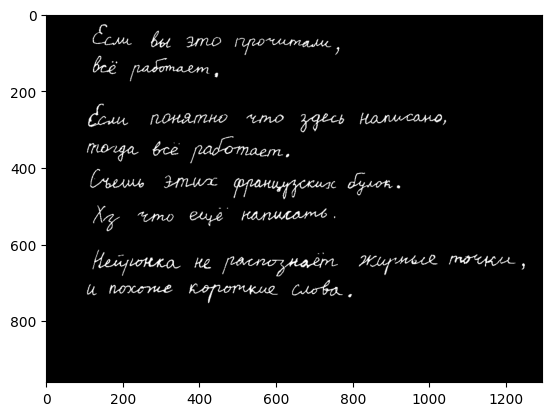

In [428]:
plt.imshow(img_binary, cmap='gray')
plt.show()

In [438]:
def adaptive_threshold_clustering(distances_list, multiplier=2):
  """Используем кластеризацию для разделения на 2 группы"""
  if len(distances_list) == 0:
    return 1

  if np.all(distances_list == distances_list[0]):
    return distances_list[0]

  q25, q75 = np.percentile(distances_list, [25, 75])
  iqr = q75 - q25

  if iqr > q25:
      multiplier = 1.8
  else:
      multiplier = 1.5

  upper_bound = q75 + multiplier * iqr

  # print(f"Адаптивные границы: Q75={q75}, IQR={iqr}, Верхняя граница={upper_bound}")

  reasonable_upper_limit = max(50, upper_bound)
  filtered = distances_list[distances_list <= reasonable_upper_limit].reshape(-1, 1)


  kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42, n_init=10)
  labels = kmeans.fit_predict(filtered)
  centers = kmeans.cluster_centers_.flatten()
  sorted_indices = np.argsort(centers)
  small_cluster_idx = sorted_indices[0]

  large_cluster_idx = sorted_indices[1]

  large_cluster_values = filtered[labels == large_cluster_idx]
  if len(large_cluster_values) == 0:
    large_cluster_values = filtered[labels == small_cluster_idx]
  threshold = np.min(large_cluster_values)

  return float(threshold)

def collect_statistic(rows):
  """находим меж контурное расстояние для каждой строки"""
  thresholds = []
  count = 0
  for row in rows:
    count += 1
    groups = []
    used = set()
    d = np.array([])
    group_tail = None
    for i in range(len(row)):
        if i in used:
            continue
        if group_tail:
          d = np.append(d, row[i][0] - group_tail)
        group_tail = row[i][0] + row[i][2]
        used.add(i)
        queue = [i]
        while queue:
            current_idx = queue.pop(0)

            for j in range(len(row)):
                if j in used:
                    continue
                distance_hor = calculate_rect_distance(row[current_idx],
                                                     row[j])
                if distance_hor == 0:
                    group_tail = max(group_tail, row[j][0] + row[j][2])
                    used.add(j)
                    queue.append(j)
    thresholds.append(adaptive_threshold_clustering(d))

  return thresholds



24


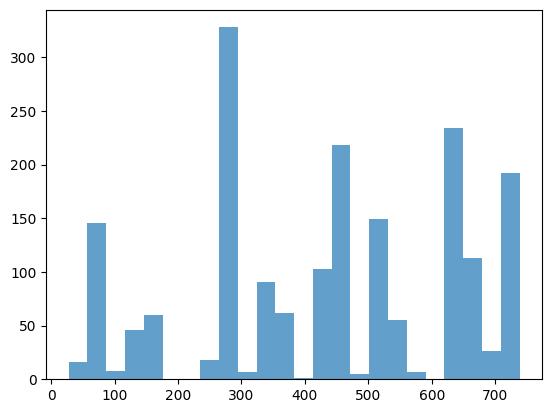

In [434]:
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bins = auto_adjust_bins()
print(bins)

sorted_row_contours = group_contours_histogram(contours, bins=bins)

In [420]:
statistics = collect_statistic(sorted_row_contours)

q10, q90 = np.percentile(statistics, 30), np.percentile(statistics, 90)

hor_dist_thrs = np.clip(statistics, q10, q90)


[34.0, 31.0, 47.0, 25.0, 40.0, 34.0, 27.0, 24.0] 32.5


In [435]:
res = img.copy()
res_area = res.shape[0] * res.shape[1]

rows = []
count = 0
for row in sorted_row_contours:
  bboxes = []
  row = [cnt for cnt in np.array(row, dtype=np.int32)]
  merged_contours = merge_close_contours(row, hor_dist_thrs=hor_dist_thrs[count])
  count += 1
  for i, contour in enumerate(merged_contours):
    x, y, w, h = cv2.boundingRect(contour)
    if w * h >= res_area * 0.8:
      continue
    cv2.rectangle(res,(x,y),(x+w,y+h),(0,255,0),2)
    bboxes.append([x, y, w, h])
  rows.append(bboxes)


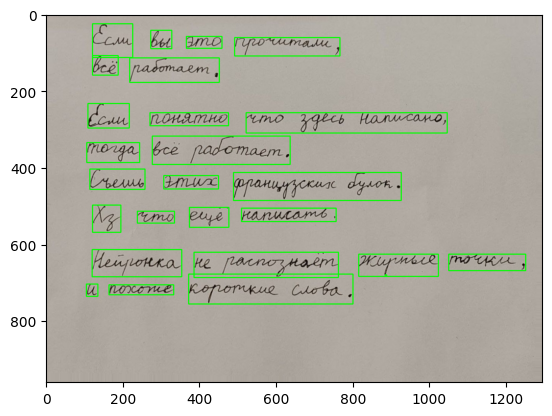

In [436]:
plt.imshow(res)
plt.show()